In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    #torchvision.transforms.Resize(14),      # Resize the image
    transforms.ToTensor(),                  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

img_res = images.shape[3]

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [4]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        self.layers = layers
        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.build_layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.build_layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.layers = layers
        self.num_parameters = self.count_params(layers, grid_size)
        self.build_layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.build_layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [5]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, img_res*img_res).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, img_res*img_res).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t     Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [6]:
def build_data_frame(model, num_epochs, train_losses, train_accs, val_losses, val_accs, time, separator):

    dfs = [pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        }) for _ in range(2)]
    
    df, df_to_csv = dfs
    
    df_to_csv = pd.concat([df_to_csv, pd.DataFrame([{'Epoch': 'Mean', 'Time': df_to_csv['Time'].mean()}])], ignore_index=True)
    df_to_csv = pd.concat([df_to_csv, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df_to_csv = pd.concat([df_to_csv, separator], ignore_index=True)

    return df, df_to_csv

In [7]:
# Define models and parameters

model_list_mlp = [
    #MyMLP([img_res*img_res, 128, 10]),
    #MyMLP([img_res*img_res, 64, 10]),
    MyMLP([img_res*img_res, 15, 10]),
    #MyMLP([img_res*img_res, 5, 10]),
    #MyMLP([img_res*img_res, 10, 10, 10]),
    MyMLP([img_res*img_res, 5, 5, 10]),
    ]
model_list_kan = [
    #MyKAN([img_res*img_res, 128, 10], grid_size=3),
    #MyKAN([img_res*img_res, 64, 10], grid_size=3),
    #MyKAN([img_res*img_res, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 10], grid_size=3),
    #MyKAN([img_res*img_res, 10, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

dfs = [pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time']) for _ in range(4)]
df_mlp, df_mlp_to_csv, df_kan, df_kan_to_csv = dfs
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp, single_df_mlp_to_csv = build_data_frame(model_mlp, num_epochs, train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp, separator)
    single_df_kan, single_df_kan_to_csv = build_data_frame(model_kan, num_epochs, train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan, separator)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)
    df_mlp_to_csv = pd.concat([df_mlp_to_csv, single_df_mlp_to_csv], ignore_index=True)
    df_kan_to_csv = pd.concat([df_kan_to_csv, single_df_kan_to_csv], ignore_index=True)

Training model "MyMLP" [784, 15, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11935



100%|██████████| 938/938 [00:07<00:00, 130.34it/s]


Epoch [1/10], Train Loss: 0.5672, Train Accuracy: 0.8410, Time: 7.20s
	     Valid Loss: 0.3528, Valid Accuracy: 0.9030



100%|██████████| 938/938 [00:06<00:00, 145.16it/s]


Epoch [2/10], Train Loss: 0.3397, Train Accuracy: 0.9036, Time: 6.46s
	     Valid Loss: 0.3203, Valid Accuracy: 0.9125



100%|██████████| 938/938 [00:06<00:00, 140.14it/s]


Epoch [3/10], Train Loss: 0.3146, Train Accuracy: 0.9104, Time: 6.69s
	     Valid Loss: 0.2979, Valid Accuracy: 0.9219



100%|██████████| 938/938 [00:06<00:00, 142.45it/s]


Epoch [4/10], Train Loss: 0.3025, Train Accuracy: 0.9140, Time: 6.59s
	     Valid Loss: 0.2973, Valid Accuracy: 0.9206



100%|██████████| 938/938 [00:06<00:00, 139.67it/s]


Epoch [5/10], Train Loss: 0.2945, Train Accuracy: 0.9165, Time: 6.72s
	     Valid Loss: 0.2889, Valid Accuracy: 0.9233



100%|██████████| 938/938 [00:06<00:00, 147.25it/s]


Epoch [6/10], Train Loss: 0.2847, Train Accuracy: 0.9198, Time: 6.37s
	     Valid Loss: 0.2979, Valid Accuracy: 0.9207



100%|██████████| 938/938 [00:06<00:00, 150.56it/s]


Epoch [7/10], Train Loss: 0.2804, Train Accuracy: 0.9204, Time: 6.23s
	     Valid Loss: 0.2760, Valid Accuracy: 0.9273



100%|██████████| 938/938 [00:06<00:00, 146.39it/s]


Epoch [8/10], Train Loss: 0.2771, Train Accuracy: 0.9223, Time: 6.41s
	     Valid Loss: 0.3223, Valid Accuracy: 0.9095



100%|██████████| 938/938 [00:06<00:00, 144.08it/s]


Epoch [9/10], Train Loss: 0.2722, Train Accuracy: 0.9231, Time: 6.51s
	     Valid Loss: 0.2806, Valid Accuracy: 0.9221



100%|██████████| 938/938 [00:06<00:00, 142.56it/s]


Epoch [10/10], Train Loss: 0.2690, Train Accuracy: 0.9242, Time: 6.58s
	     Valid Loss: 0.2705, Valid Accuracy: 0.9288

Training model "MyKAN" [784, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11910



100%|██████████| 938/938 [00:07<00:00, 120.65it/s]


Epoch [1/10], Train Loss: 0.8766, Train Accuracy: 0.7212, Time: 7.78s
	     Valid Loss: 0.5590, Valid Accuracy: 0.8374



100%|██████████| 938/938 [00:07<00:00, 119.67it/s]


Epoch [2/10], Train Loss: 0.5002, Train Accuracy: 0.8507, Time: 7.84s
	     Valid Loss: 0.4523, Valid Accuracy: 0.8773



100%|██████████| 938/938 [00:07<00:00, 121.96it/s]


Epoch [3/10], Train Loss: 0.4237, Train Accuracy: 0.8799, Time: 7.69s
	     Valid Loss: 0.4116, Valid Accuracy: 0.8907



100%|██████████| 938/938 [00:07<00:00, 121.75it/s]


Epoch [4/10], Train Loss: 0.3846, Train Accuracy: 0.8927, Time: 7.71s
	     Valid Loss: 0.3804, Valid Accuracy: 0.9022



100%|██████████| 938/938 [00:07<00:00, 122.29it/s]


Epoch [5/10], Train Loss: 0.3599, Train Accuracy: 0.8989, Time: 7.67s
	     Valid Loss: 0.3659, Valid Accuracy: 0.9077



100%|██████████| 938/938 [00:07<00:00, 124.38it/s]


Epoch [6/10], Train Loss: 0.3423, Train Accuracy: 0.9050, Time: 7.54s
	     Valid Loss: 0.3536, Valid Accuracy: 0.9097



100%|██████████| 938/938 [00:07<00:00, 124.12it/s]


Epoch [7/10], Train Loss: 0.3300, Train Accuracy: 0.9096, Time: 7.56s
	     Valid Loss: 0.3802, Valid Accuracy: 0.8983



100%|██████████| 938/938 [00:07<00:00, 124.77it/s]


Epoch [8/10], Train Loss: 0.3208, Train Accuracy: 0.9112, Time: 7.52s
	     Valid Loss: 0.3436, Valid Accuracy: 0.9102



100%|██████████| 938/938 [00:07<00:00, 124.38it/s]


Epoch [9/10], Train Loss: 0.3129, Train Accuracy: 0.9137, Time: 7.54s
	     Valid Loss: 0.3374, Valid Accuracy: 0.9151



100%|██████████| 938/938 [00:07<00:00, 123.77it/s]


Epoch [10/10], Train Loss: 0.3058, Train Accuracy: 0.9157, Time: 7.58s


/tmp/ipykernel_11972/3337914836.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
/tmp/ipykernel_11972/3337914836.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)


	     Valid Loss: 0.3336, Valid Accuracy: 0.9157

Training model "MyMLP" [784, 5, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4015



100%|██████████| 938/938 [00:06<00:00, 139.66it/s]


Epoch [1/10], Train Loss: 1.5715, Train Accuracy: 0.4209, Time: 6.72s
	     Valid Loss: 1.2984, Valid Accuracy: 0.5554



100%|██████████| 938/938 [00:06<00:00, 144.25it/s]


Epoch [2/10], Train Loss: 1.1999, Train Accuracy: 0.5718, Time: 6.50s
	     Valid Loss: 1.1253, Valid Accuracy: 0.6146



100%|██████████| 938/938 [00:06<00:00, 142.67it/s]


Epoch [3/10], Train Loss: 1.0952, Train Accuracy: 0.6192, Time: 6.58s
	     Valid Loss: 1.0708, Valid Accuracy: 0.6348



100%|██████████| 938/938 [00:06<00:00, 143.06it/s]


Epoch [4/10], Train Loss: 1.0466, Train Accuracy: 0.6381, Time: 6.56s
	     Valid Loss: 1.0343, Valid Accuracy: 0.6476



100%|██████████| 938/938 [00:06<00:00, 137.09it/s]


Epoch [5/10], Train Loss: 1.0253, Train Accuracy: 0.6466, Time: 6.84s
	     Valid Loss: 1.0063, Valid Accuracy: 0.6671



100%|██████████| 938/938 [00:06<00:00, 142.75it/s]


Epoch [6/10], Train Loss: 1.0140, Train Accuracy: 0.6525, Time: 6.57s
	     Valid Loss: 0.9981, Valid Accuracy: 0.6725



100%|██████████| 938/938 [00:06<00:00, 143.45it/s]


Epoch [7/10], Train Loss: 1.0043, Train Accuracy: 0.6567, Time: 6.54s
	     Valid Loss: 0.9930, Valid Accuracy: 0.6752



100%|██████████| 938/938 [00:06<00:00, 144.13it/s]


Epoch [8/10], Train Loss: 1.0007, Train Accuracy: 0.6576, Time: 6.51s
	     Valid Loss: 0.9896, Valid Accuracy: 0.6694



100%|██████████| 938/938 [00:06<00:00, 143.81it/s]


Epoch [9/10], Train Loss: 0.9921, Train Accuracy: 0.6616, Time: 6.52s
	     Valid Loss: 0.9932, Valid Accuracy: 0.6753



100%|██████████| 938/938 [00:06<00:00, 143.68it/s]


Epoch [10/10], Train Loss: 0.9885, Train Accuracy: 0.6631, Time: 6.53s
	     Valid Loss: 0.9881, Valid Accuracy: 0.6804

Training model "MyKAN" [784, 5, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11985



100%|██████████| 938/938 [00:08<00:00, 109.18it/s]


Epoch [1/10], Train Loss: 1.0746, Train Accuracy: 0.6691, Time: 8.59s
	     Valid Loss: 0.5647, Valid Accuracy: 0.8397



100%|██████████| 938/938 [00:08<00:00, 109.36it/s]


Epoch [2/10], Train Loss: 0.4819, Train Accuracy: 0.8594, Time: 8.58s
	     Valid Loss: 0.4346, Valid Accuracy: 0.8806



100%|██████████| 938/938 [00:08<00:00, 109.92it/s]


Epoch [3/10], Train Loss: 0.4106, Train Accuracy: 0.8822, Time: 8.54s
	     Valid Loss: 0.4028, Valid Accuracy: 0.8881



100%|██████████| 938/938 [00:08<00:00, 106.95it/s]


Epoch [4/10], Train Loss: 0.3795, Train Accuracy: 0.8920, Time: 8.77s
	     Valid Loss: 0.3824, Valid Accuracy: 0.8948



100%|██████████| 938/938 [00:08<00:00, 110.86it/s]


Epoch [5/10], Train Loss: 0.3599, Train Accuracy: 0.8974, Time: 8.46s
	     Valid Loss: 0.3594, Valid Accuracy: 0.9036



100%|██████████| 938/938 [00:08<00:00, 111.07it/s]


Epoch [6/10], Train Loss: 0.3460, Train Accuracy: 0.9016, Time: 8.45s
	     Valid Loss: 0.3538, Valid Accuracy: 0.9025



100%|██████████| 938/938 [00:09<00:00, 104.02it/s]


Epoch [7/10], Train Loss: 0.3330, Train Accuracy: 0.9059, Time: 9.02s
	     Valid Loss: 0.3494, Valid Accuracy: 0.9055



100%|██████████| 938/938 [00:08<00:00, 104.47it/s]


Epoch [8/10], Train Loss: 0.3250, Train Accuracy: 0.9084, Time: 8.98s
	     Valid Loss: 0.3464, Valid Accuracy: 0.9074



100%|██████████| 938/938 [00:08<00:00, 110.86it/s]


Epoch [9/10], Train Loss: 0.3168, Train Accuracy: 0.9094, Time: 8.46s
	     Valid Loss: 0.3362, Valid Accuracy: 0.9129



100%|██████████| 938/938 [00:08<00:00, 106.53it/s]


Epoch [10/10], Train Loss: 0.3107, Train Accuracy: 0.9125, Time: 8.81s
	     Valid Loss: 0.3419, Valid Accuracy: 0.9081



In [8]:
df_mlp_to_csv.to_csv('results_mlp.csv', index = False)
df_kan_to_csv.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_11972/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


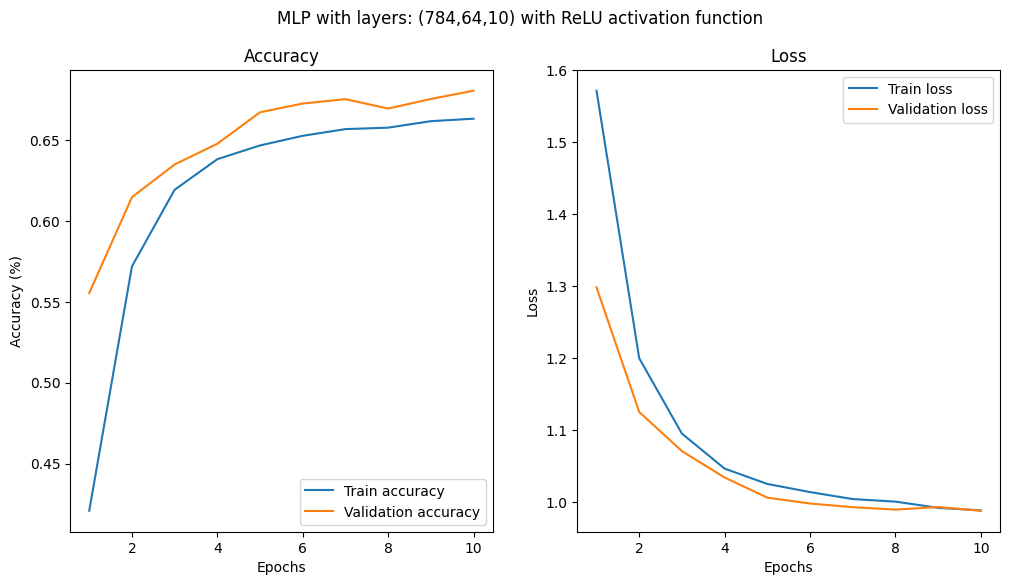

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_11972/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


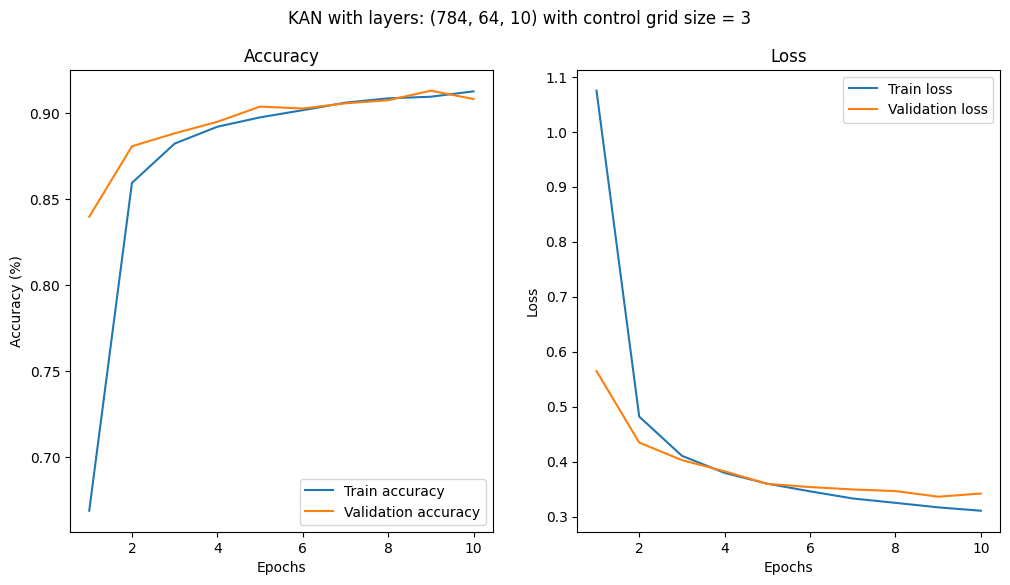

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()